In [1]:
import librosa
import os
import glob
import IPython.display as ipd
from pathlib import Path
import timeit

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import cv2
import seaborn as sns

%tensorflow_version 1.x #version 1 works without problems
import tensorflow


from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation, GaussianNoise, LSTM
from sklearn.metrics import accuracy_score



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x #version 1 works without problems`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


# Access data in drive and make ready for use

In [2]:
#authorize colab to use data in google drive
from google.colab import drive 
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#create path to dataset and check if it finds genres
DATA_DIR = Path('/content/gdrive/My Drive/genres/') 
genres = [x.name for x in DATA_DIR.glob('*') if x.is_dir()]
genres

['blues',
 'rock',
 'classical',
 'disco',
 'hiphop',
 'metal',
 'pop',
 'jazz',
 'country',
 'reggae']

In [0]:
def create_paths_ds(paths: Path, label: str) -> list:
    EXTENSION_TYPE = '.wav'
    return [(x, label) for x in paths.glob('*' + EXTENSION_TYPE)]

In [5]:
categories_to_use = [ #choose the genres used 
    'classical',
    'hiphop',
    'metal',
    # 'disco',
    # 'reggae',
    'country',
]

#overwriting classes to all classes
# categories_to_use = categories

NUM_CLASSES = len(categories_to_use)

print(f'Number of classes: {NUM_CLASSES}')

paths_all_labels = []
for cat in categories_to_use:
    paths_all_labels += create_paths_ds(DATA_DIR / cat, cat)


X_train, X_test = train_test_split(paths_all_labels,test_size=0.1)
X_train, X_val = train_test_split(X_train, test_size=0.2)

print(f'Train length: {len(X_train)}')
print(f'Validation length: {len(X_val)}')
print(f'Test length: {len(X_test)}')

Number of classes: 4
Train length: 288
Validation length: 72
Test length: 40


In [0]:
def load_and_preprocess_cnn(dataset, SAMPLE_SIZE = 30):
    IMG_SIZE = (216,128) 
    progress = 0

    data = []
    labels = []
    for (path, label) in dataset:
        audio, sr = librosa.load(path)
        dur = librosa.get_duration(audio, sr = sr)
        sampleNum = int(dur / SAMPLE_SIZE)
        offset = (dur % SAMPLE_SIZE) / 2
        for i in range(sampleNum):
            audio, sr = librosa.load(path, offset= offset+i, duration=SAMPLE_SIZE)
            sample = librosa.feature.melspectrogram(audio, sr=sr)
            # print(sample.shape)
            sample = cv2.resize(sample, dsize=IMG_SIZE)
            sample = np.expand_dims(sample,-1) #the cnn needs 3 dimensions to work
            data += [(sample, label)]
            labels += [label]

        progress +=1
        print('\r Progress: '+str(round(100*progress/len(dataset))) + '%', end='')
    return data, labels

In [0]:
def load_and_preprocess_lstm(dataset, SAMPLE_SIZE = 30):
    IMG_SIZE = (216,128) 
    progress=0

    data = []
    labels = []
    for (path, label) in dataset:
        audio, sr = librosa.load(path)
        dur = librosa.get_duration(audio, sr = sr)
        sampleNum = int(dur / SAMPLE_SIZE)
        offset = (dur % SAMPLE_SIZE) / 2
        for i in range(sampleNum):
            audio, sr = librosa.load(path, offset= offset+i, duration=SAMPLE_SIZE)
            sample = librosa.feature.melspectrogram(audio, sr=sr)
            # print(sample.shape)
            sample = cv2.resize(sample, dsize=IMG_SIZE)
            data += [(sample, label)]
            labels += [label]
        progress +=1
        print('\r Progress: '+str(round(100*progress/len(dataset))) + '%', end='')
    return data, labels

---

# Loading and preprocessing the samples for train test and validation data

In [0]:
def retrieve_samples(sample_size, model_type): #in this function we create

    if model_type == 'cnn':
  
        print("\nLoading train samples")
        X_train_samples, train_labels = load_and_preprocess_cnn(X_train,sample_size)
        print("\nLoading test samples")
        X_test_samples, test_labels = load_and_preprocess_cnn(X_test,sample_size)
        print("\nLoading val samples")
        X_val_samples, val_labels = load_and_preprocess_cnn(X_val,sample_size)
        print("")
    
    elif model_type == 'lstm':

        print("\nLoading train samples")
        X_train_samples, train_labels = load_and_preprocess_lstm(X_train,sample_size)
        print("\nLoading test samples")
        X_test_samples, test_labels = load_and_preprocess_lstm(X_test,sample_size)
        print("\nLoading val samples")
        X_val_samples, val_labels = load_and_preprocess_lstm(X_val,sample_size)      
        print("")

    # print("shape: " + str(X_train_samples[0][0].shape))
    # print("number of training samples: "+ str(len(X_train_samples)))
    # print("number of validation samples: "+ str(len(X_val_samples)))
    # print("number of test samples: "+ str(len(X_test_samples)))


    return X_train_samples, X_test_samples, X_val_samples

---
# Build the models

In [18]:
#Define Model

def create_cnn_model(input_shape):
  # input_shape = X_train_samples[0][0].shape

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(GaussianNoise(0.1))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax')) #Compile
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
  # print(model.summary())
  return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 214, 126, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 212, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 106, 62, 64)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 106, 62, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 106, 62, 64)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 420608)            0         
______________________________________

SyntaxError: ignored

In [0]:
def create_lstm_model(input_shape):
    model = Sequential()

    model.add(LSTM(units = 128, dropout=0.05, recurrent_dropout=0.35, return_sequences = True, input_shape = (128, 216)))
    model.add(LSTM(units = 64, dropout=0.05, recurrent_dropout=0.35, return_sequences = False))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))#Compile

    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    # print(model.summary())

    return model

---
# Final data preperation for training models


In [0]:
def create_model_data_and_labels(X_train_samples, X_val_samples, X_test_samples):
    #Prepare samples to work for training the model
    labelizer = LabelEncoder()

    #prepare training data and labels
    x_train = np.array([x[0] for x in X_train_samples])
    y_train = np.array([x[1] for x in X_train_samples])
    y_train = labelizer.fit_transform(y_train) 
    y_train = to_categorical(y_train)

    #prepare validation data and labels
    x_val = np.array([x[0] for x in X_val_samples])
    y_val = np.array([x[1] for x in X_val_samples])
    y_val = labelizer.transform(y_val)
    y_val = to_categorical(y_val)

    #prepare test data and labels
    x_test = np.array([x[0] for x in X_test_samples])
    y_test = np.array([x[1] for x in X_test_samples])
    y_test = labelizer.transform(y_test)
    y_test = to_categorical(y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test, labelizer

---
# Metrics analysis & Visualization

In [0]:
def plot_data(history, ss):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    sns.set(font_scale=1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('model_accuracy_size_'+str(ss)+'.png')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('model_loss_size_'+str(ss)+'.png')
    plt.show()
    

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


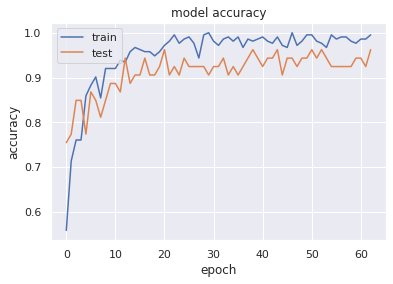

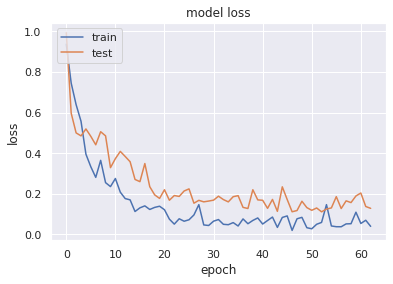

In [0]:
plot_data(history)

## BEST model: do evaluation

In [0]:
def plot_conf_matrix(predictions, y_test, ss):
    matrix = confusion_matrix(labelizer.inverse_transform(y_test.argmax(axis=1)), 
                          labelizer.inverse_transform(predictions.argmax(axis=1)), 
                         labels=labelizer.classes_
                         )

    matrix = pd.DataFrame(matrix, index=labelizer.classes_, columns=labelizer.classes_)

    fig, ax = plt.subplots(figsize=(8, 8))

    sns.set(font_scale=2.5)
    sns.heatmap(matrix, annot=True, fmt='.2f', linewidth=5, cmap="Greens")
    ax.set_title('Confusion Matrix for (mis)classifications \n with sample size: '+str(ss)+ ' seconds')
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True values');

    fig.savefig('conf_matrix_size_'+str(ss)+'.png', bbox_inches='tight') #

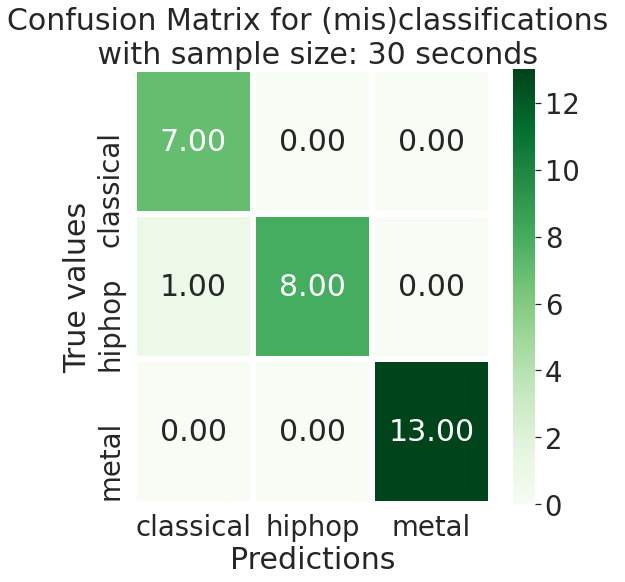

In [0]:

plot_conf_matrix(predictions, y_test,30)


# Main Loop for the full procedure

In [16]:
#Main loop for testing multiple sample sizes

#choose model type: cnn or ltsm
model_type = 'cnn'

n_epochs = 200
patience = 10
es = EarlyStopping(patience=10)
sample_sizes = [5,10,15,30]
start = timeit.default_timer()

ModelData = pd.DataFrame(columns = ['Model Type','Sample size (s)', 'Time to Compute (s)',  'Early Stopping epoch', 'Training accuracy', 'Validation accuracy', 'Test Accuracy']) #create a DataFrame for storing the results 

conf_matrix_data = []

for i in sample_sizes:

    start_per_size = timeit.default_timer()

    print(f'\n---------- Model trained on samples of size: {i} seconds ----------------')
    X_train_samples, X_test_samples, X_val_samples = retrieve_samples(i,model_type)
    x_train, y_train, x_val, y_val, x_test, y_test, labelizer = create_model_data_and_labels(X_train_samples, X_val_samples, X_test_samples)

    if model_type == 'cnn':
        model = create_cnn_model(X_train_samples[0][0].shape)
    elif model_type == 'lstm':
        model = create_lstm_model(X_train_samples[0][0].shape)


    history = model.fit(x_train, y_train, 
              batch_size = 8, 
              epochs=n_epochs,
              verbose=1, 
              callbacks=[es],
              validation_data=(x_val, y_val))
    print('Finished training')


    early_stopping_epoch = len(history.history['accuracy'])
    training_accuracy = history.history['accuracy'][early_stopping_epoch-1-patience]
    validation_accuracy = history.history['val_accuracy'][early_stopping_epoch-1-patience]

    plot_data(history, i)

    predictions = model.predict(x_test)
    score = accuracy_score(labelizer.inverse_transform(y_test.argmax(axis=1)), labelizer.inverse_transform(predictions.argmax(axis=1)))

    print('Sample size = ' + str(i) + ' seconds')
    print('Accuracy on test samples: ' + str(score))
    
    conf_matrix_data += [(predictions, y_test, i)]

    stop_per_size = timeit.default_timer()
    time_to_compute = round(stop_per_size - start_per_size)

    print ('Time to compute: '+str(time_to_compute))

    ModelData.loc[len(ModelData)] = [model_type, i, time_to_compute, early_stopping_epoch, training_accuracy, validation_accuracy, score] #store particular settings configuration, early stoppping epoch and accuracies in dataframe

stop = timeit.default_timer()
print ('\ntime to compute: '+str(stop-start))


---------- Model trained on samples of size: 5 seconds ----------------

Loading train samples
 Progress: 0%

KeyboardInterrupt: ignored

In [0]:
print(ModelData)

ModelData.head()

import os.path
from google.colab import files


filenumber=1
while os.path.isfile('ModelData'+str(filenumber)+'.csv'): #find the first free file
    filenumber += 1

ModelData.to_csv(r'ModelData'+str(filenumber)+'.csv') #store data in the first free csv file
files.download('ModelData'+str(filenumber)+'.csv') #download csv file 

  Model Type Sample size (s)  ... Validation accuracy Test Accuracy
0       lstm               5  ...            0.777778      0.844444
1       lstm              10  ...            0.808642      0.788889
2       lstm              15  ...            0.833333      0.816667
3       lstm              30  ...            0.796296      0.766667

[4 rows x 7 columns]


In [0]:
#reads a csv file and converts it to a LaTeX table
ModelDataLatex = pd.read_csv('ModelData1.csv')
print(ModelDataLatex.to_latex(index=False)) 

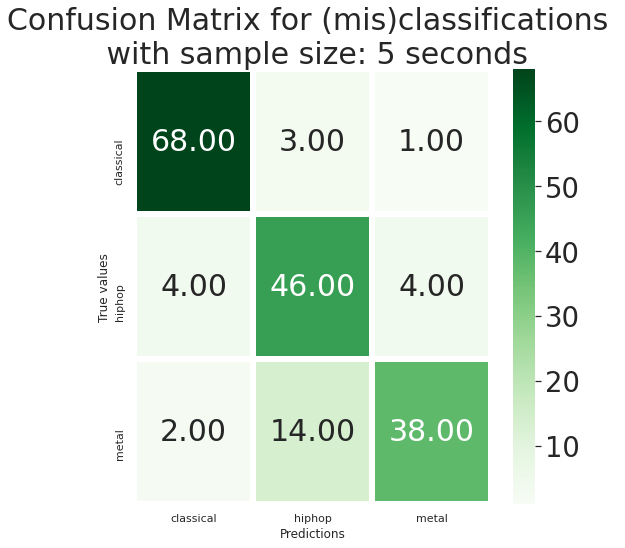

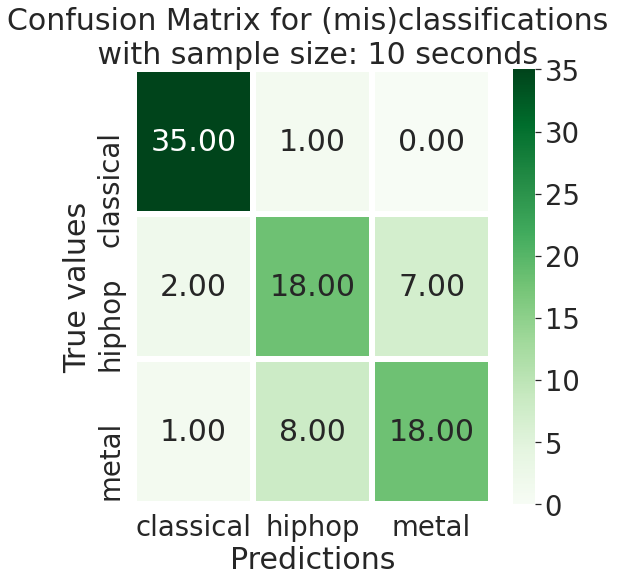

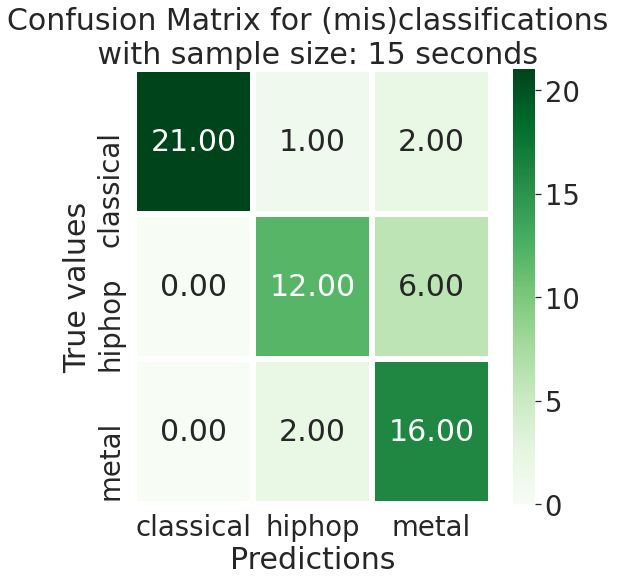

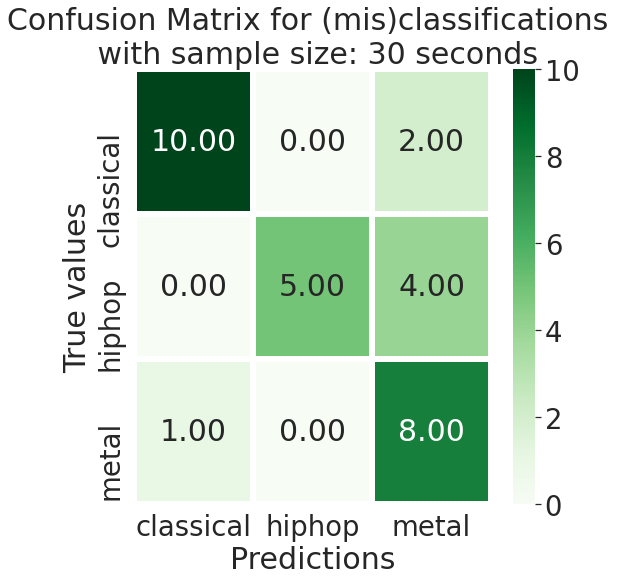

In [0]:
#plot confusion matrices for the given input sample sizes
for j in conf_matrix_data:
    plot_conf_matrix(j[0], j[1], j[2])
